In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.

Create a grid using pre-determined reference x and y values; perform a 500mb height analysis 
of given 500mb height observations using the Gilchrist and Cressman (1954) second order, 
two-dimensional polynomial using both a 10cm and 20cm radius of influence (on a 1/15000000 map 
scale); store both the grid point analysis values and the number of observations used to compute
the analysis values as text files and contour plots.

Code modified and augmented for the assignment by Ev Bohlmann (with significant edits/troubleshooting by the esteemed Dr. Marquis).
"""

'\nCreated By    : Jared W. Marquis\nCreation Date : 01 August 2022\nCourse        : ATSC 528 - Atmospheric Data Analysis\nAssignment    : #01 - Function Fitting\n\nPurpose:\nScript to take sparse upper air observations and analyze them on a\npolar stereographic map projection using function fitting.\n\nCreate a grid using \n\nCode modified and augmented by Ev Bohlmann (with significant edits/troubleshooting by the esteemed Dr. Marquis)\n'

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [3]:
### Read in observations ###
dat = np.loadtxt('RAOBs_201903131200.txt',delimiter=',',skiprows=0,usecols=(1,2,3,4,5))
#print(dat)
datt = dat.T
## datt array has lats; lons; 500mb heights; wind direction; wind speed in that order as the rows
## shove all of these fields into their own arrays to call by name
lat = datt[0]
lon = datt[1]
hght = datt[2]
wdir = datt[3]
wspd = datt[4]

r = 6371000 #units of meters
scale = 1/15000000
## grab the min max of lons and lats for future reference
minlat = np.min(lat)
maxlat = np.max(lat)
minlon = np.min(lon)
maxlon = np.max(lon)


In [4]:
### Set up analysis map with a 22x28 rectangular grid of points ###

## create evenly spaced point grid
def grid():#(shape=(22,28)):
    ## get grid point locations, using values already in meters because i'm allergic to nonstandard units
    #glon = np.arange(.189,((.0127*28)+.189),.0127)
    glon = .189 + (np.arange(22)*0.0127)
    glat = -0.063 + (np.arange(28)*0.0127)
    #glat = np.arange((-.0630+(.0127*21)),-.0630+.0127,.0127) ## i never claimed to be an efficient programmer
    return(glon,glat)

glon,glat = grid()

## shove it all into meshgrid to get actual gridpoints out of this
xg,yg = np.meshgrid(glon,glat)

## plot for quality control
#plt.plot(xg,yg,color='black',marker='o',linestyle='none')


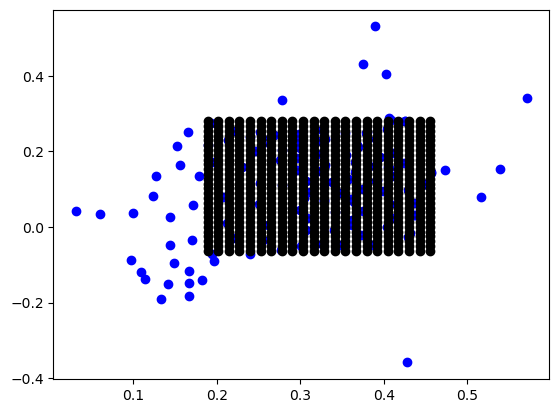

In [5]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###

## create analysis points lat/lon array
obsloc = np.zeros(shape=(len(lat),2)) ## to be filled with values
for i in range(len(lat)):
    pointlat = lat[i]
    pointlon = lon[i]
    obsloc[i] = pointlat,pointlon ## now, each row will have a lat/lon pair in that order
#print(obsloc)
dx = .0127
dy = .0127
rho = 6371000

m = 1/15000000

x0 = .1890
y0 = -.0630
l0 = (-115 * np.pi/180)
## define function to take the lat/lon points and convert them to centimeter locations using the long and frankly ridiculous formula from the notes
def obsdist(lat,lon):
    sig = (1 + np.sin(60 * np.pi/180))/(1 + np.sin(lat * np.pi/180)) ## have to bake in the radians conversion because that's how numpy rolls ig
    x = m * rho * sig * np.cos(lat * np.pi/180) * np.cos((lon * np.pi/180)-l0)
    y = m * rho * sig * np.cos(lat * np.pi/180) * np.sin((lon * np.pi/180)-l0)
    return(x,y)

obsxy = np.zeros(shape=(len(lat),2))
for i in range(len(lat)):
    this_latlon = obsloc[i]
    this_lat = this_latlon[0]
    this_lon = this_latlon[1]
    x,y = obsdist(this_lat,this_lon)
    obsxy[i] = x,y
## incredibly cringe how long the above block of code took me

obsxyt = obsxy.T
obsx = obsxyt[0]
obsy = obsxyt[1]

plt.plot(obsx,obsy,color='blue',marker='o',linestyle='none')
plt.plot(xg,yg,color='black',marker='o',linestyle='none')

## this looks stoopid
## whatever

## create analysis x,y to analysis lat,lon function
def latlon(x,y):
    #alat = ((np.pi/2) * (180/np.pi)) - ((2*np.arctan(((x**2 + y**2)**.5)/(rho * (1 + np.sin(60 * np.pi/180))))) / (np.pi/180))
    alat = ( (np.pi/2) - (2 * np.arctan((((x**2) + (y**2))**0.5)/(rho * (1 + np.sin(60 * np.pi/180)))))/m ) * (180/np.pi)
    alon = -115 - (np.arctan(y/x) / (np.pi/180)) 
    return(alat,alon)

## toss analysis points through the latlon function defined
alat,alon = latlon(xg,yg)
## aaaand toss those outputs into a meshgrid
anlat,anlon = np.meshgrid(alat,alon)


In [6]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###
roi10 = .10
roi20 = .20
roi6 = .06 

ahghts10 = np.zeros((28,22))
ahghts20 = np.zeros((28,22))
ahghts6 = np.zeros((28,22))
#print(ahghts)

pts10 = np.zeros((28,22))
pts20 = np.zeros((28,22))
pts6 = np.zeros((28,22))

## setup the matrix bs (10cm ROI)
for i in range(len(xg)):
    for j in range(len(xg[i])):
        xa = xg[i,j]
        ya = yg[i,j]
        dx = xa - obsx
        dy = ya - obsy
        dist = ((dx**2 + dy**2)**0.5)
        idx = np.where(dist <= roi10)
        obs_used = np.shape(idx)
        num_obs = obs_used[1]
        x = dx[idx]
        y = dy[idx]
        xk = np.mean(dx[idx])
        yk = np.mean(dy[idx])
        x2k = np.mean(x * x)
        y2k = np.mean(y * y)
        xkyk = np.mean(x * y)
        x3k = np.mean(x * x * x)
        xky2k = np.mean(x * y * y)
        x2kyk = np.mean(x * x * y)
        y3k = np.mean(y * y * y)
        x4k = np.mean(x * x * x * x)
        x2ky2k = np.mean(x * x * y * y)
        x3kyk = np.mean(x * x * x * y)
        y4k = np.mean(y * y * y * y)
        xky3k = np.mean(x * y * y * y)
        f = hght[idx]
        f0 = np.mean(f)
        xf0 = np.mean(f * x)
        yf0 = np.mean(f * y)
        x2f0 = np.mean(f * x * x)
        y2f0 = np.mean(f * y * y)
        xyf0 = np.mean(f * x * y)

        mat = np.matrix([[1,xk,yk,x2k,y2k,xkyk],
               [xk,x2k,xkyk,x3k,xky2k,x2kyk],
               [yk,xkyk,y2k,x2kyk,y3k,xky2k],
               [x2k,x3k,x2kyk,x4k,x2ky2k,x3kyk],
               [y2k,xky2k,y3k,x2ky2k,y4k,xky3k],
               [xkyk,x2kyk,xky2k,x3kyk,xky3k,x2ky2k]])

        fmat = np.matrix([[f0],[xf0],[yf0],[x2f0],[y2f0],[xyf0]])
        coef = np.linalg.inv(mat) * fmat
        ahghts10[i,j] = coef[0]
        pts10[i,j] = num_obs
        #print(coef[0])

## again for 20cm ROI
for i in range(len(xg)):
    for j in range(len(xg[i])):
        xa = xg[i,j]
        ya = yg[i,j]
        dx = xa - obsx
        dy = ya - obsy
        dist = ((dx**2 + dy**2)**0.5)
        idx = np.where(dist <= roi20)
        obs_used = np.shape(idx)
        num_obs = obs_used[1]
        x = dx[idx]
        y = dy[idx]
        xk = np.mean(dx[idx])
        yk = np.mean(dy[idx])
        x2k = np.mean(x * x)
        y2k = np.mean(y * y)
        xkyk = np.mean(x * y)
        x3k = np.mean(x * x * x)
        xky2k = np.mean(x * y * y)
        x2kyk = np.mean(x * x * y)
        y3k = np.mean(y * y * y)
        x4k = np.mean(x * x * x * x)
        x2ky2k = np.mean(x * x * y * y)
        x3kyk = np.mean(x * x * x * y)
        y4k = np.mean(y * y * y * y)
        xky3k = np.mean(x * y * y * y)
        f = hght[idx]
        f0 = np.mean(f)
        xf0 = np.mean(f * x)
        yf0 = np.mean(f * y)
        x2f0 = np.mean(f * x * x)
        y2f0 = np.mean(f * y * y)
        xyf0 = np.mean(f * x * y)

        mat = np.matrix([[1,xk,yk,x2k,y2k,xkyk],
               [xk,x2k,xkyk,x3k,xky2k,x2kyk],
               [yk,xkyk,y2k,x2kyk,y3k,xky2k],
               [x2k,x3k,x2kyk,x4k,x2ky2k,x3kyk],
               [y2k,xky2k,y3k,x2ky2k,y4k,xky3k],
               [xkyk,x2kyk,xky2k,x3kyk,xky3k,x2ky2k]])

        fmat = np.matrix([[f0],[xf0],[yf0],[x2f0],[y2f0],[xyf0]])
        coef = np.linalg.inv(mat) * fmat
        ahghts20[i,j] = coef[0]
        pts20[i,j] = num_obs
        #print(coef[0])


C:\Users\evieb\AppData\Local\Temp\ipykernel_18112\1352831207.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ahghts10[i,j] = coef[0]
C:\Users\evieb\AppData\Local\Temp\ipykernel_18112\1352831207.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ahghts20[i,j] = coef[0]


In [14]:
## a 3rd time for 6cm ROI
for i in range(len(xg)):
    for j in range(len(xg[i])):
        xa = xg[i,j]
        ya = yg[i,j]
        dx = xa - obsx
        dy = ya - obsy
        dist = ((dx**2 + dy**2)**0.5)
        idx = np.where(dist <= .06)
        obs_used = np.shape(idx)
        num_obs = obs_used[1]
        x = dx[idx]
        y = dy[idx]
        xk = np.mean(dx[idx])
        yk = np.mean(dy[idx])
        x2k = np.mean(x * x)
        y2k = np.mean(y * y)
        xkyk = np.mean(x * y)
        x3k = np.mean(x * x * x)
        xky2k = np.mean(x * y * y)
        x2kyk = np.mean(x * x * y)
        y3k = np.mean(y * y * y)
        x4k = np.mean(x * x * x * x)
        x2ky2k = np.mean(x * x * y * y)
        x3kyk = np.mean(x * x * x * y)
        y4k = np.mean(y * y * y * y)
        xky3k = np.mean(x * y * y * y)
        f = hght[idx]
        f0 = np.mean(f)
        xf0 = np.mean(f * x)
        yf0 = np.mean(f * y)
        x2f0 = np.mean(f * x * x)
        y2f0 = np.mean(f * y * y)
        xyf0 = np.mean(f * x * y)

        mat = np.matrix([[1,xk,yk,x2k,y2k,xkyk],
               [xk,x2k,xkyk,x3k,xky2k,x2kyk],
               [yk,xkyk,y2k,x2kyk,y3k,xky2k],
               [x2k,x3k,x2kyk,x4k,x2ky2k,x3kyk],
               [y2k,xky2k,y3k,x2ky2k,y4k,xky3k],
               [xkyk,x2kyk,xky2k,x3kyk,xky3k,x2ky2k]])
        fmat = np.matrix([[f0],[xf0],[yf0],[x2f0],[y2f0],[xyf0]])
        coef = np.linalg.inv(mat) * fmat
        ahghts6[i,j] = coef[0]

C:\Users\evieb\AppData\Local\Temp\ipykernel_18112\1981465592.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ahghts6[i,j] = coef[0]


LinAlgError: Singular matrix

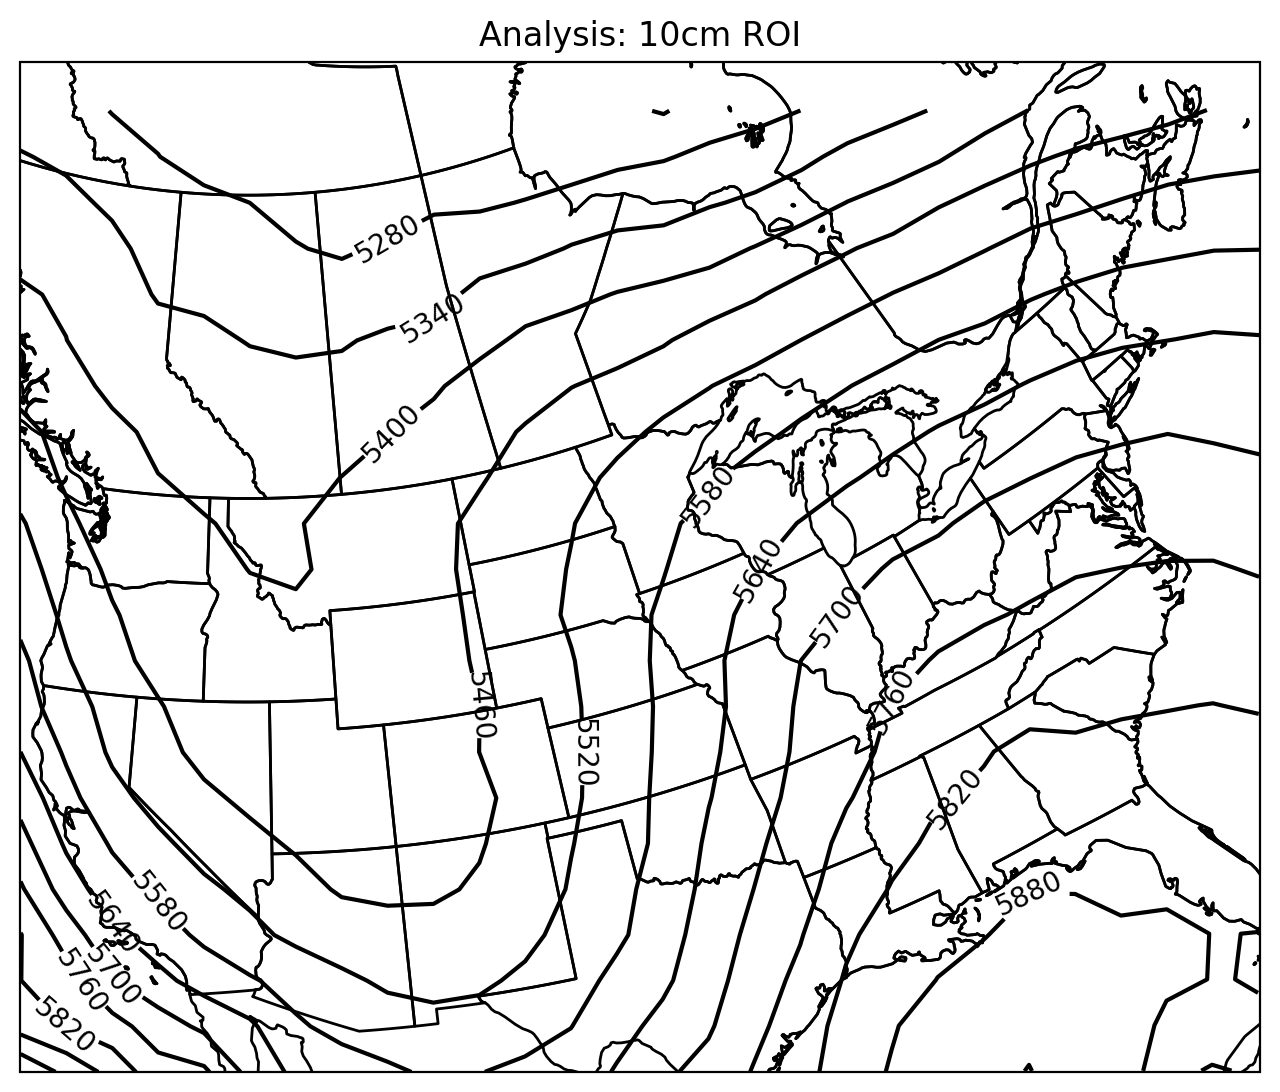

In [8]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#
def latlon(x,y):
    #lat = ((np.pi/2) - (2*np.arctan((((((x/m)**2 + (y/m)**2)**.5)/(rho * (1 + np.sin(60 * np.pi/180))))*np.pi/180)))) * (180/np.pi)
    lat = ((np.pi/2) - (2 * np.arctan( (((x/m)**2 + (y/m)**2)**.5) / (rho * (1 + np.sin(60 * (np.pi/180)))) ))) * (180/np.pi)
    lon = np.arctan(y/x)*(180/np.pi) - 115
    return(lat,lon)

anlat,anlon = latlon(xg,yg)
#print(latlon(xg,yg))
#print(anlon)

## plot starts here 
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis 
cs1 = ax1.contour(anlon,anlat,ahghts10,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis 500mb Heights')
plt.savefig('og_analysis.png',dpi=200,bbox_inches='tight')
plt.show()

## Let the record show that Jared was the one to un-break my analysis code, I only changed the variable names in the map code, and I have no idea why the Colorado Line isn't there

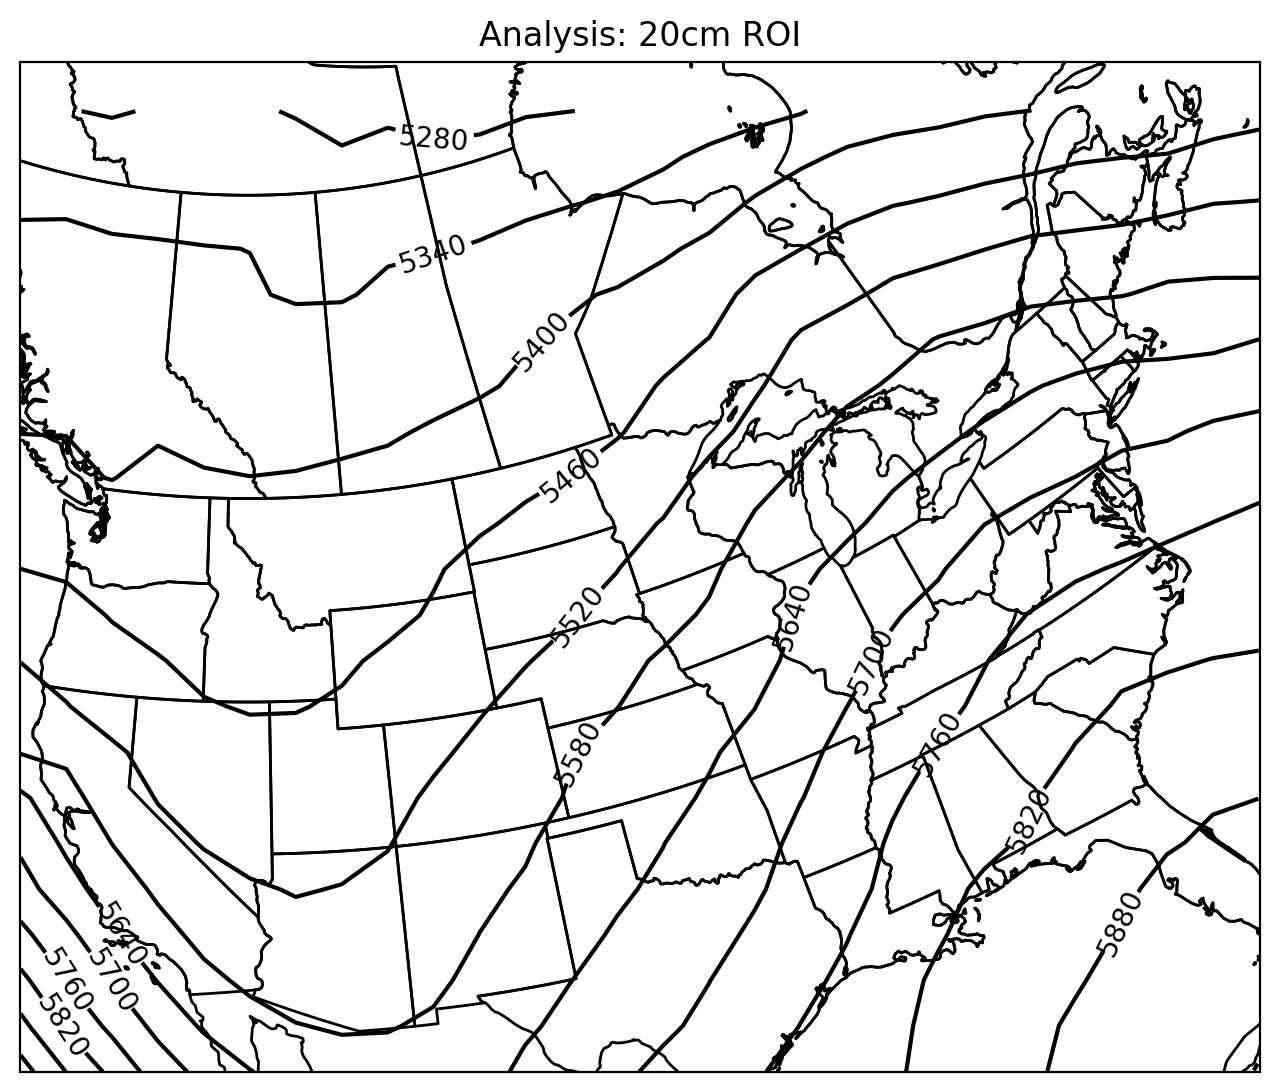

In [9]:
## plot starts here for 20cm ROI
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(anlon,anlat,ahghts20,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis: 20cm ROI')
plt.savefig('20cmanalysis.png',dpi=200,bbox_inches='tight')

## Let the record show that Jared was the one to fix my analysis code, I only changed the variable names in the map code, and I have no idea why the Colorado Line isn't there

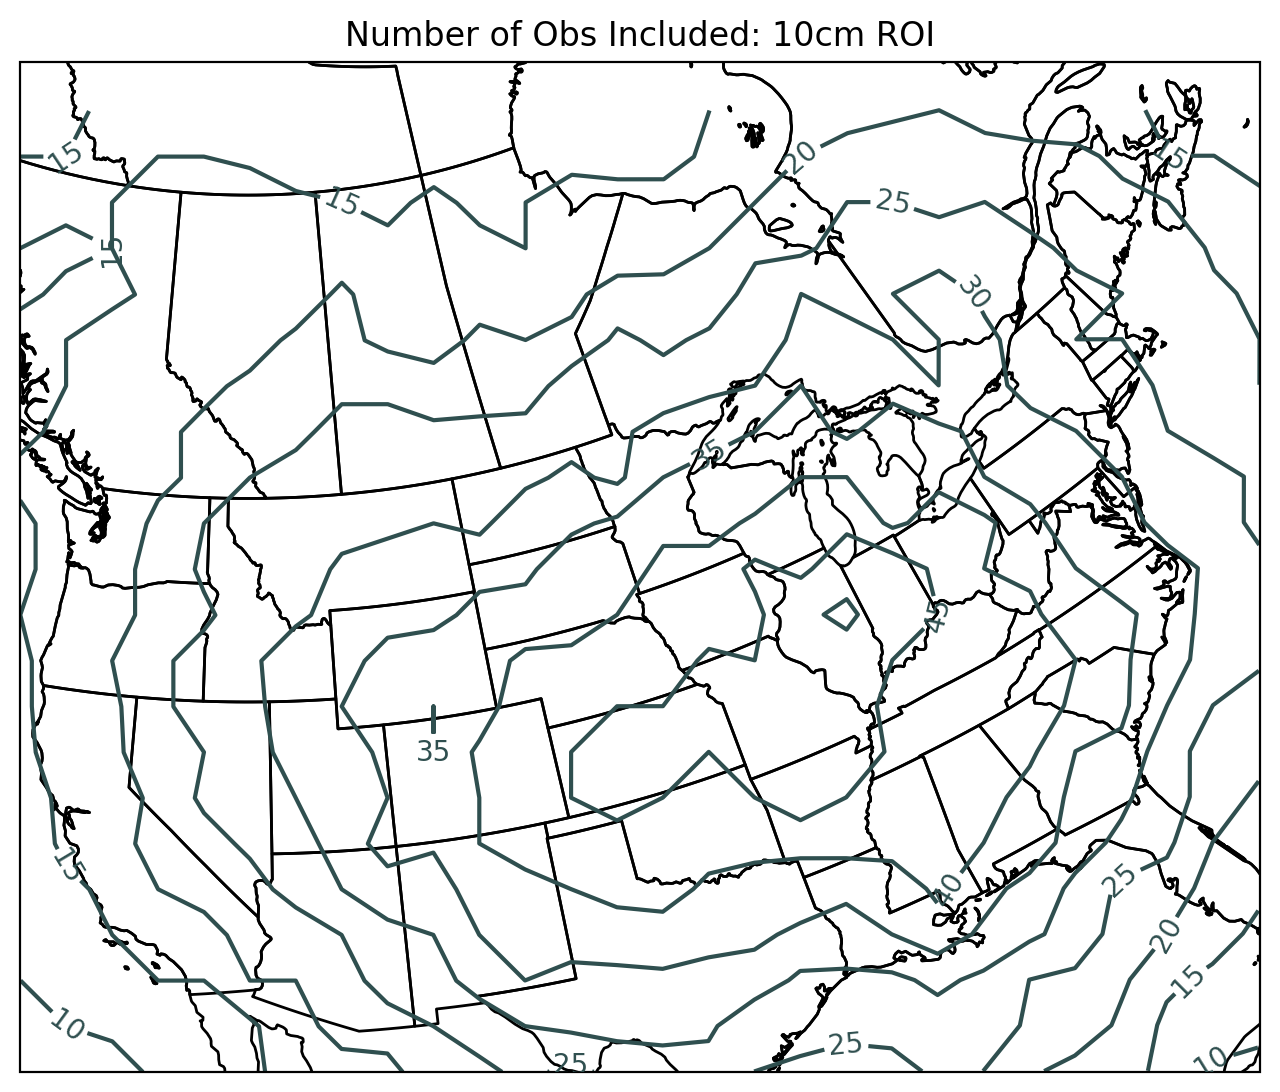

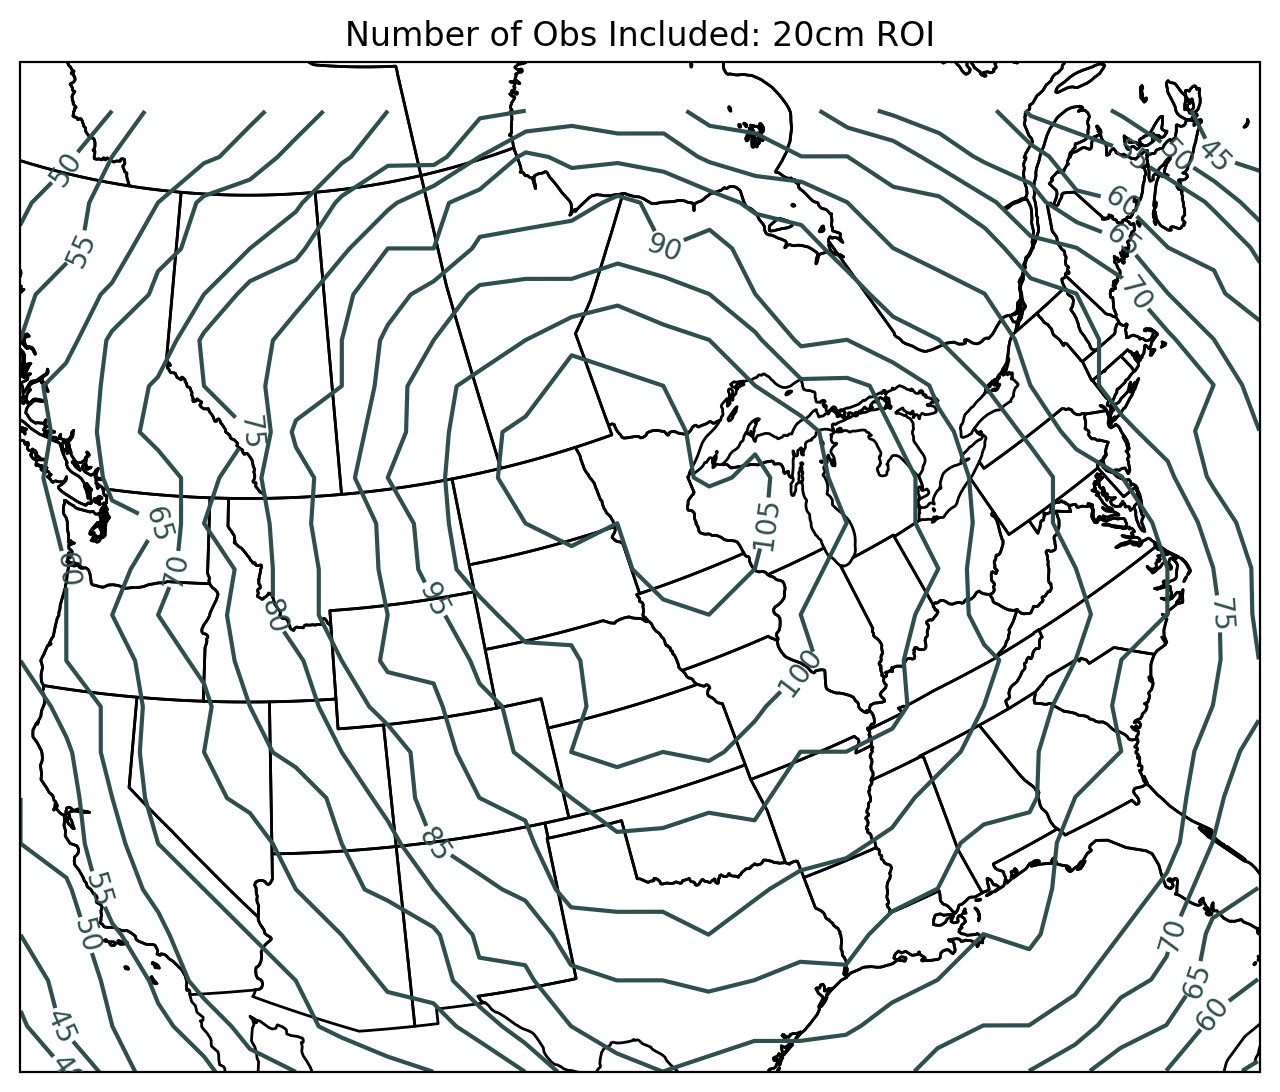

In [10]:
## plot contoured number of obs included in analysis points (10cm)
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(anlon,anlat,pts10,colors='darkslategrey',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,5))
plt.title('Number of Obs Included: 10cm ROI')
plt.savefig('10cm_num_obs.png',dpi=200,bbox_inches='tight')

## plot contoured number of obs included in analysis points (10cm)
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(anlon,anlat,pts20,colors='darkslategrey',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,5))
plt.title('Number of Obs Included: 20cm ROI')
plt.savefig('20cm_num_obs.png',dpi=200,bbox_inches='tight')


In [11]:
### Store the analyses in text files ###
an10 = open('10cmanalysisvals.txt','w')

for i in ahghts10:
    j = i.astype(str)
    an10.write(f'{j}')

an10.close()

an20 = open('20cmanalysisvals.txt','w')

for i in ahghts20:
    j = i.astype(str)
    an20.write(f'{j}')

an20.close()

In [12]:
### Store the number of observations available for each grid point in text files ###
obs10 = open('10cmnumobs.txt','w')

for i in pts10:
    j = i.astype(str)
    obs10.write(f'{j}')

obs10.close()

obs20 = open('20cmnumbobs.txt','w')

for i in pts20:
    j = i.astype(str)
    obs20.write(f'{j}')


In [13]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

    Neutral-tilted trough over the western USA; complementary ridge with an axis approximately 
    over Appalachia. Trough appears to have a slight negative tilt in the 10cm analysis, but not the 20cm analysis.

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?

    The 20cm analysis is smoother. Because the ROI is larger, more data is averaged out into 
    each analysis point, and the overlap between included data points will be greater. More of 
    the noise will be removed this way. 
    The way that I think of it is bringing the map one step closer to being a homogeneous 
    average of values with a larger ROI, because the radius would include more and more overlap.

    The 10cm analysis also appears to have a stronger height gradient, with the gradient being "cinched" 
    over the Midwest and Plains states. The trough is not necessarily deeper, but the change occurs over a
    shorter distance than in the 20cm analysis. There's a local maximum in included points over the Midwest 
    that drops off significantly to the west, due in part to the lack of observations available there. The change
    in included observations from the Midwest to the intermountain west is much less drastic with the 20cm ROI.

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?

    There is a major problem and it is that my matrix throws up a "singular matrix" error. Separation of some grid 
    point values, for whatever reason, is so astronomically small (approx. 10^-70) that it functionally makes the determinant zero for
    some grid points. If the ROI is small enough, there may be observations getting excluded entirely, or there may be grid points without
    any observations to be based off of. Alternatively, a singular unrealistic observation being included at an analysis point would
    create some wacky contours (technical term).
   
4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?

    No. The observation and grid point dx's and dy's would be minimal with a small ROI, some grid points may not
    even have an observation available, and the determinant for at least some grid points could be zero.
    They would, therefore, not be invertible. (See broken ROI of 6cm.)

'''

'\n1 - Describe the general features that you see in your contoured analyses.\n\n    Neutral-tilted trough over the western USA; complementary ridge with an axis approximately \n    over Appalachia. Trough appears to have a slight negative tilt in the 10cm analysis, but not the 20cm analysis.\n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n\n    The 20cm analysis is smoother. Because the ROI is larger, more data is averaged out into \n    each analysis point, and the overlap between included data points will be greater. More of \n    the noise will be removed this way. \n    The way that I think of it is bringing the map one step closer to being a homogeneous \n    average of values with a larger ROI, because the radius would include more and more overlap.\n\n    The 10cm analysis also appears to have a stronger height gradient, with the gradient being "cinched" \n    o